# Two implementations of heterodyne detection: direct heterodyne and as two homodyne measurements

Copyright (C) 2011 and later, Paul D. Nation & Robert J. Johansson

In [1]:
%matplotlib inline

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
from qutip import *

## Introduction

Homodyne and hetrodyne detection are techniques for measuring the quadratures of a field using photocounters. Homodyne detection (on-resonant) measures one quadrature and with heterodyne detection (off-resonant) both quadratures can be detected simulateously.

The evolution of a quantum system that is coupled to a field that is monitored with homodyne and heterodyne detector can be described with stochastic master equations. This notebook compares two different ways to implement the heterodyne detection stochastic master equation in QuTiP.

## Deterministic reference

In [15]:
N = 5
w0 = 1.0 * 2 * np.pi
A = 0.1 * 2 * np.pi
times = np.linspace(0, 15, 150)
gamma = 0.25

ntraj = 250
nsubsteps = 250

a = destroy(N)
x = a + a.dag()
y = -1.0j*(a - a.dag())

H = w0 * a.dag() * a + A * (a + a.dag())

rho0 = coherent(N, np.sqrt(5.0), method='analytic')
c_ops = [np.sqrt(gamma) * a]
e_ops = [a.dag() * a, x, y]

In [16]:
result_ref = mesolve(H, rho0, times, c_ops, e_ops)

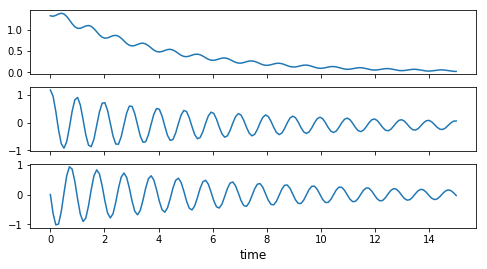

In [17]:
plot_expectation_values(result_ref);

## Heterodyne implementation #1

Stochastic master equation for heterodyne in Milburn's formulation

$\displaystyle d\rho(t) = -i[H, \rho(t)]dt + \gamma\mathcal{D}[a]\rho(t) dt + \frac{1}{\sqrt{2}} dW_1(t) \sqrt{\gamma} \mathcal{H}[a] \rho(t) + \frac{1}{\sqrt{2}} dW_2(t) \sqrt{\gamma} \mathcal{H}[-ia] \rho(t)$

where $\mathcal{D}$ is the standard Lindblad dissipator superoperator, and $\mathcal{H}$ is defined as above,
and $dW_i(t)$ is a normal distributed increment with $E[dW_i(t)] = \sqrt{dt}$.


In QuTiP format we have:

$\displaystyle d\rho(t) = -i[H, \rho(t)]dt +  D_{1}[A]\rho(t) dt + D_{2}^{(1)}[A]\rho(t) dW_1 + D_{2}^{(2)}[A]\rho(t) dW_2$

where $A = \sqrt{\gamma} a$, so we can identify

$\displaystyle D_{1}[A]\rho = \gamma \mathcal{D}[a]\rho = \mathcal{D}[A]\rho$

In [8]:
from qutip.expect import expect_rho_vec

In [9]:
def d1_rho_func(t, rho_vec, A, args):
    return A[7] * rho_vec

$D_{2}^{(1)}[A]\rho = \frac{1}{\sqrt{2}} \sqrt{\gamma} \mathcal{H}[a] \rho =
\frac{1}{\sqrt{2}} \mathcal{H}[A] \rho =
\frac{1}{\sqrt{2}}(A\rho + \rho A^\dagger - \mathrm{Tr}[A\rho + \rho A^\dagger] \rho)
\rightarrow \frac{1}{\sqrt{2}} \left\{(A_L +  A_R^\dagger)\rho_v - \mathrm{Tr}[(A_L +  A_R^\dagger)\rho_v] \rho_v\right\}$

$D_{2}^{(2)}[A]\rho = \frac{1}{\sqrt{2}} \sqrt{\gamma} \mathcal{H}[-ia] \rho 
= \frac{1}{\sqrt{2}} \mathcal{H}[-iA] \rho =
\frac{-i}{\sqrt{2}}(A\rho - \rho A^\dagger - \mathrm{Tr}[A\rho - \rho A^\dagger] \rho)
\rightarrow \frac{-i}{\sqrt{2}} \left\{(A_L -  A_R^\dagger)\rho_v - \mathrm{Tr}[(A_L - A_R^\dagger)\rho_v] \rho_v\right\}$

In [10]:
def d2_rho_func(t, rho_vec, A, args):

    B = A[0] + A[3]
    e1 = expect_rho_vec(B, rho_vec, False)
    drho1 = B * rho_vec - e1 * rho_vec

    B = A[0] - A[3]
    e1 = expect_rho_vec(B, rho_vec, False)
    drho2 = B * rho_vec - e1 * rho_vec

    return [1.0/np.sqrt(2) * drho1, -1.0j/np.sqrt(2) * drho2]

The heterodyne currents for the $x$ and $y$ quadratures are

$J_x(t) = \sqrt{\gamma}\left<x\right> + \sqrt{2} \xi(t)$

$J_y(t) = \sqrt{\gamma}\left<y\right> + \sqrt{2} \xi(t)$

where $\xi(t) = \frac{dW}{dt}$.

In qutip we define these measurement operators using the `m_ops = [[x, y]]` and the coefficients to the noise terms `dW_factor = [sqrt(2/gamma), sqrt(2/gamma)]`.

In [11]:
result = smesolve(H, rho0, times, [], c_ops, e_ops, 
                  ntraj=ntraj, nsubsteps=nsubsteps,
                  d1=d1_rho_func, d2=d2_rho_func, d2_len=2,
                  dW_factors=[np.sqrt(2/gamma), np.sqrt(2/gamma)], m_ops=[[x, y]],
                  distribution='normal', store_measurement=True,
                  map_func=parallel_map)

10.0%. Run time:  47.69s. Est. time left: 00:00:07:09
20.0%. Run time:  88.71s. Est. time left: 00:00:05:54


Process ForkPoolWorker-2:
Process ForkPoolWorker-8:
Process ForkPoolWorker-6:
Process ForkPoolWorker-3:
Process ForkPoolWorker-7:
Process ForkPoolWorker-5:
Process ForkPoolWorker-4:
Process ForkPoolWorker-1:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/usr/local/lib/python3.5/dist-packages/qutip/stochastic.py",

  File "/usr/local/lib/python3.5/dist-packages/scipy/sparse/sputils.py", line 141, in get_index_dtype
    int32max = np.iinfo(np.int32).max
  File "/usr/local/lib/python3.5/dist-packages/numpy/core/getlimits.py", line 514, in __init__
    self.key = "%s%d" % (self.kind, self.bits)
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
plot_expectation_values([result, result_ref]);

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))

for m in result.measurement:
    ax.plot(times, m[:, 0, 0].real, 'b', alpha=0.05)
    ax.plot(times, m[:, 0, 1].real, 'r', alpha=0.05)

ax.plot(times, result_ref.expect[1], 'b', lw=2);
ax.plot(times, result_ref.expect[2], 'r', lw=2);

ax.set_ylim(-25, 25)
ax.set_xlim(0, times.max())
ax.set_xlabel('time', fontsize=12)
ax.plot(times, np.array(result.measurement).mean(axis=0)[:,0,0].real, 'k', lw=2);
ax.plot(times, np.array(result.measurement).mean(axis=0)[:,0,1].real, 'k', lw=2);

## Heterodyne implementation #2: using two homodyne measurements


We can also write the heterodyne equation as

$\displaystyle d\rho(t) = -i[H, \rho(t)]dt + \frac{1}{2}\gamma\mathcal{D}[a]\rho(t) dt + \frac{1}{\sqrt{2}} dW_1(t) \sqrt{\gamma} \mathcal{H}[a] \rho(t) + \frac{1}{2}\gamma\mathcal{D}[a]\rho(t) dt + \frac{1}{\sqrt{2}} dW_2(t) \sqrt{\gamma} \mathcal{H}[-ia] \rho(t)$


And using the QuTiP format for two stochastic collapse operators, we have:

$\displaystyle d\rho(t) = -i[H, \rho(t)]dt + D_{1}[A_1]\rho(t) dt + D_{2}[A_1]\rho(t) dW_1 + D_{1}[A_2]\rho(t) dt + D_{2}[A_2]\rho(t) dW_2$

so we can also identify

$\displaystyle D_{1}[A_1]\rho = \frac{1}{2}\gamma \mathcal{D}[a]\rho = \mathcal{D}[\sqrt{\gamma}a/\sqrt{2}]\rho = \mathcal{D}[A_1]\rho$

$\displaystyle D_{1}[A_2]\rho = \frac{1}{2}\gamma \mathcal{D}[a]\rho = \mathcal{D}[-i\sqrt{\gamma}a/\sqrt{2}]\rho = \mathcal{D}[A_2]\rho$


$D_{2}[A_1]\rho = \frac{1}{\sqrt{2}} \sqrt{\gamma} \mathcal{H}[a] \rho = \mathcal{H}[A_1] \rho$

$D_{2}[A_2]\rho = \frac{1}{\sqrt{2}} \sqrt{\gamma} \mathcal{H}[-ia] \rho  = \mathcal{H}[A_2] \rho $

where $A_1 = \sqrt{\gamma} a / \sqrt{2}$ and $A_2 = -i \sqrt{\gamma} a / \sqrt{2}$.

In summary we have

$\displaystyle d\rho(t) = -i[H, \rho(t)]dt + \sum_i\left\{\mathcal{D}[A_i]\rho(t) dt + \mathcal{H}[A_i]\rho(t) dW_i\right\}$

which is a simultaneous homodyne detection with $A_1 = \sqrt{\gamma}a/\sqrt{2}$ and $A_2 = -i\sqrt{\gamma}a/\sqrt{2}$

Here the two heterodyne currents for the $x$ and $y$ quadratures are

$J_x(t) = \sqrt{\gamma/2}\left<x\right> + \xi(t)$

$J_y(t) = \sqrt{\gamma/2}\left<y\right> + \xi(t)$

where $\xi(t) = \frac{dW}{dt}$.

In qutip we can use the predefined homodyne solver for solving this problem.

In [ ]:
result = smesolve(H, rho0, times, [], [np.sqrt(gamma/2) * a, -1.0j * np.sqrt(gamma/2) * a],
                  e_ops, ntraj=ntraj, nsubsteps=nsubsteps,
                  m_ops=[[x], [y]], dW_factors=[np.sqrt(2/gamma)],
                  method='homodyne', store_measurement=True,
                  map_func=parallel_map)

In [ ]:
plot_expectation_values([result, result_ref]);

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))

for m in result.measurement:
    ax.plot(times, m[:, 0].real, 'b', alpha=0.05)
    ax.plot(times, m[:, 1].real, 'r', alpha=0.05)

ax.plot(times, result_ref.expect[1], 'b', lw=2);
ax.plot(times, result_ref.expect[2], 'r', lw=2);

ax.set_xlim(0, times.max())
ax.set_ylim(-15, 15)
ax.set_xlabel('time', fontsize=12)
ax.plot(times, np.array(result.measurement).mean(axis=0)[:,0].real, 'k', lw=2);
ax.plot(times, np.array(result.measurement).mean(axis=0)[:,1].real, 'k', lw=2);

## Implementation #3: builtin function for heterodyne

In [ ]:
result = smesolve(H, rho0, times, [], [np.sqrt(gamma) * a],
                  e_ops, ntraj=ntraj, nsubsteps=nsubsteps,
                  method='heterodyne', store_measurement=True,
                  map_func=parallel_map)

In [ ]:
plot_expectation_values([result, result_ref]);

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))

for m in result.measurement:
    ax.plot(times, m[:, 0, 0].real / np.sqrt(gamma), 'b', alpha=0.05)
    ax.plot(times, m[:, 0, 1].real / np.sqrt(gamma), 'r', alpha=0.05)

ax.plot(times, result_ref.expect[1], 'b', lw=2);
ax.plot(times, result_ref.expect[2], 'r', lw=2);

ax.set_xlim(0, times.max())
ax.set_ylim(-15, 15)
ax.set_xlabel('time', fontsize=12)
ax.plot(times, np.array(result.measurement).mean(axis=0)[:, 0, 0].real / np.sqrt(gamma), 'k', lw=2);
ax.plot(times, np.array(result.measurement).mean(axis=0)[:, 0, 1].real / np.sqrt(gamma), 'k', lw=2);

## Versions

In [ ]:
from qutip.ipynbtools import version_table

version_table()